In [3]:
import warnings

import numpy as np
from sklearn import svm
from sklearn.base import clone
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, RepeatedStratifiedKFold, train_test_split
from sklearn.neural_network import MLPClassifier

import parse_stroke_data_file

warnings.filterwarnings("ignore")


# Opis środowiska eksperymentalnego

Ewaluacja każdego klasyfikatora była wykonywana
z wykorzystaniem pięciokrotnie powtarzanej metody
2-krotnej walidacji krzyżowej

In [4]:
N_SPLITS = 2
N_REPEATS = 5

Badania były przeprowadzane dla różnej
liczby cech. Poczynając od jednej - najlepszej, według rankingu cech wyznaczonego za pomocą `SelectKBest`,
kolejno dodawane były kolejne cechy. Nasz zbiór danych miał 59 cech.


In [5]:
FEATURES_RANGE = range(1,60, 5)

Do treningu wykorzystana została sieć jednokierunkowa z jedną warstwą ukrytą.
Sprawdziliśmy 3 różne liczby neuronów w warstwie ukrytej: 20, 50 oraz 90.
Przetestowane zostały klasyfikatory z parametrem `momentum` (bezwładność) o wartościach:

- 0: brak bezwładności
- 0.9: domyślna bezwładność w dla sztucznych sieci neuronowych

In [6]:
HIDDEN_LAYER_SIZES = [20, 50, 90]
MOMENTUM_VALUES = [0.0, 0.9]

# Implementacja środowiska eksperymentalnego

Kluczową część środowiska stanowi funkcja, generująca klasyfikatory. Każdy klasyfikator otrzymuje unikatową nazwę, opisującą jego konfigurację (liczbę cech, ilośc neuronów w ukrytych warstwach, wartość parametru `momentum`).

In [7]:
def get_classifiers():
    classifiers = {}
    for num_of_features in FEATURES_RANGE:
        for hidden_layer_size in HIDDEN_LAYER_SIZES:
            for momentum_value in MOMENTUM_VALUES:
                new_classifier = MLPClassifier(
                    hidden_layer_sizes=(hidden_layer_size,), momentum=momentum_value
                )

                new_classifier.num_of_features = num_of_features

                classifiers[(
                    num_of_features,
                    hidden_layer_size,
                    momentum_value
                )] = new_classifier

    return classifiers

Po wczytaniu zbioru uczącego, następuje ewaluacja każdego z klasyfikatorów. Proces ewaluacji składa się z:

- Załadowania odpowiedniego podzbioru zbioru uczącego (określonego przez liczbę cech, na jakich ma być trenowany klasyfikator)
- Pięciokrotna ewaluacja klasyfikatora na zbiorze danych, uczących i testowych, wygenerowanych za pomocą metody walidacji krzyżowej
- Zapisania sprawności klasyfikatora, policzonej za pomocą metody `accuracy_score`

Gdy wszystkie klasyfikatory zostały ocenione, ich sprawności zostają zapisane do pliku `results.npy`.

In [9]:
X, y = parse_stroke_data_file.get_dataset_x_y()
rskf = RepeatedStratifiedKFold(
    n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=42
)  # haha śmieszna liczba 42 haha
classifiers = get_classifiers()

scores = np.zeros((len(classifiers), N_SPLITS * N_REPEATS))

for clf_id, clf_name in enumerate(classifiers):
    X_new = SelectKBest(
        chi2, k=classifiers[clf_name].num_of_features
    ).fit_transform(X, y)

    for fold_id, (train, test) in enumerate(rskf.split(X_new, y)):
        clf = clone(classifiers[clf_name])
        clf.fit(X_new[train], y[train])
        y_pred = clf.predict(X_new[test])
        scores[clf_id, fold_id] = accuracy_score(y[test], y_pred)

mean = np.mean(scores, axis=1)
std = np.std(scores, axis=1)

# for clf_id, clf_name in enumerate(classifiers):
#     print("%s: %.3f (%.2f)" % (clf_name, mean[clf_id], std[clf_id]))

np.save("results", scores)

# Analiza wyników

## Wstępne przetwarzanie wyników

Przed przystąpieniem do analizy, dane klasyfikatorów i osiągnięte sprawności zostały załadowane do tabeli `pandas`.
Pozwoli to wykonanie kolejnych wykresów.

In [10]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
from matplotlib.lines import Line2D
import pandas


clfs = get_classifiers()
scores = np.load("results.npy")

data_frame = None
first_element = True

results_python_dict = {
    'num_of_features': [ ],
    'hidden_layer_size': [ ],
    'momentum': [ ],
    'mean_score': [ ],
    'std_score': [ ]
}
for score, classifier in zip(scores, clfs):
    
    mean_score = np.mean(score)
    std_score = np.std(score)
    num_of_features, hidden_layer_size, momentum_value = classifier
    
    results_python_dict['num_of_features'].append(num_of_features)
    results_python_dict['hidden_layer_size'].append(hidden_layer_size)
    results_python_dict['momentum'].append(momentum_value)
    results_python_dict['mean_score'].append(mean_score)
    results_python_dict['std_score'].append(std_score)

results_pandas = pandas.DataFrame(results_python_dict)
del results_python_dict

print(results_pandas)

     num_of_features  hidden_layer_size  momentum  mean_score  std_score
0                  1                 20       0.0         0.0        0.0
1                  1                 20       0.9         0.0        0.0
2                  1                 50       0.0         0.0        0.0
3                  1                 50       0.9         0.0        0.0
4                  1                 90       0.0         0.0        0.0
..               ...                ...       ...         ...        ...
349               59                 20       0.9         0.0        0.0
350               59                 50       0.0         0.0        0.0
351               59                 50       0.9         0.0        0.0
352               59                 90       0.0         0.0        0.0
353               59                 90       0.9         0.0        0.0

[354 rows x 5 columns]


## Sprawność klasyfikatorów a rozmiar warstwy ukrytej

Pierwszym krokiem podjętym w celu przeanalizowania wyników było utworzenie wykresu ilustrującego uzyskaną 
przez klasyfikatory sprawność, w zależności od liczby neuronów w ukrytych warstwach.

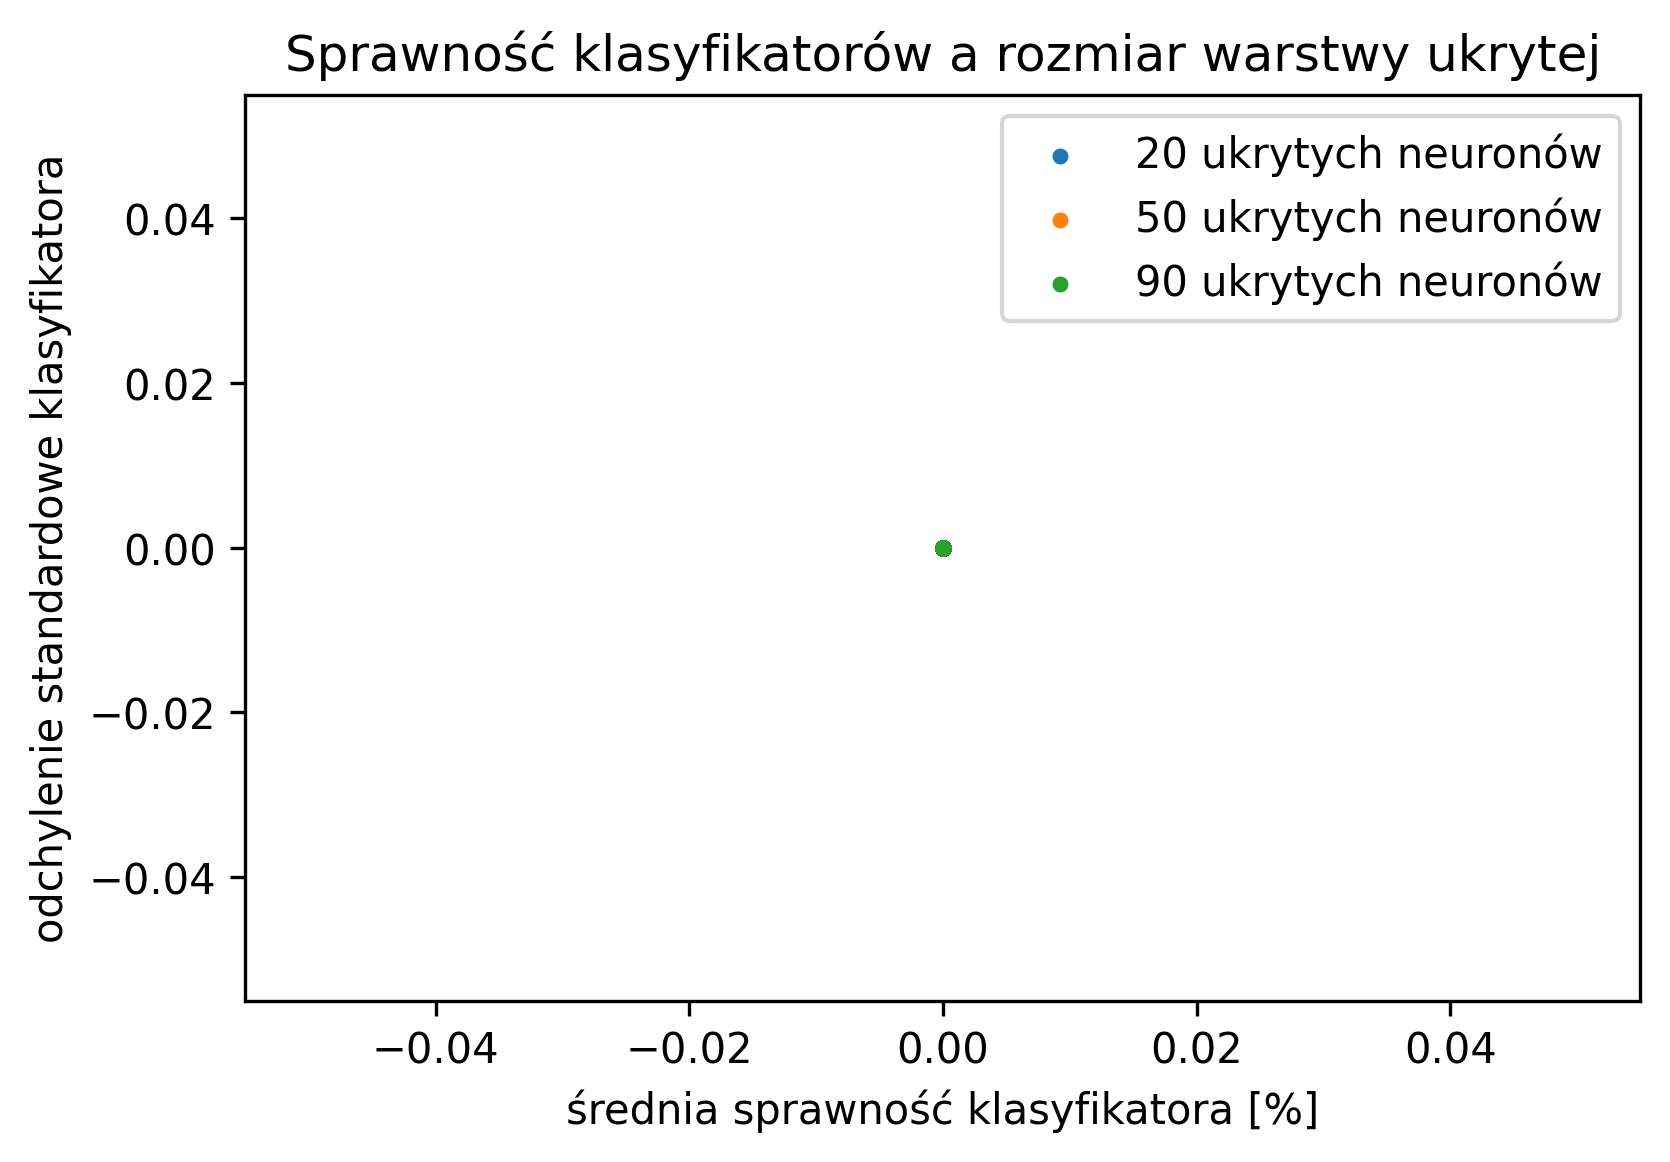

In [11]:
fig, ax = plt.subplots()

hidden_size_20 = results_pandas[results_pandas['hidden_layer_size'] == 20]
hidden_size_50 = results_pandas[results_pandas['hidden_layer_size'] == 50]
hidden_size_90 = results_pandas[results_pandas['hidden_layer_size'] == 90]

datas = [ hidden_size_20, hidden_size_50, hidden_size_90 ]
labels = [
    '20 ukrytych neuronów',
    '50 ukrytych neuronów',
    '90 ukrytych neuronów',
]

for data, label in zip(datas, labels):
    ax.scatter(
        data['mean_score'], data['std_score'], label=label, s=8
    )

plt.title('Sprawność klasyfikatorów a rozmiar warstwy ukrytej')
ax.set_xlabel('średnia sprawność klasyfikatora [%]')
ax.set_ylabel('odchylenie standardowe klasyfikatora')
ax.legend()
plt.show()

Na wykresie dostrzegalna jest niewielka przewaga klasyfikatorów o większej liczbie neuronów w warstwie ukrytej. 
Zarówno pod względem sprawności jak i odchylenia standardowego, są one lepsze niż klasyfikatory o mniejszej liczbie 
neuronów.

## Sprawność klasyfikacji a ilość cech

In [1]:
fig, ax = plt.subplots()

for hidden_layer_size in [20, 50, 90]:
    for momentum_value in [0.0, 0.9]:
        result = results_pandas[results_pandas['hidden_layer_size'] == hidden_layer_size]
        result = result[result['momentum'] != momentum_value]
        ax.plot(result['num_of_features'], result['mean_score'], label=f'{hidden_layer_size} ukrytych neuronów, momentum {momentum_value}')

ax.legend()
plt.show()

NameError: name 'plt' is not defined

In [2]:
top_10_by_acccuracy = results_pandas.sort_values(by='mean_score', ascending=False).head(10)
top_10_by_acccuracy

NameError: name 'results_pandas' is not defined

In [11]:
results_pandas.sort_values(by='std_score', ascending=True).head(10)

,num_of_features,hidden_layer_size,momentum,mean_score,std_score
4,1,90,0.0,0.291897,0.000786
5,1,90,0.9,0.292341,0.001303
172,29,90,0.0,0.773365,0.007899
137,23,90,0.9,0.756495,0.008293
345,58,50,0.9,0.801330,0.008305
292,49,90,0.0,0.819534,0.008431
347,58,90,0.9,0.811764,0.008479
119,20,90,0.9,0.756267,0.008688
27,5,50,0.9,0.618873,0.008928
328,55,90,0.0,0.821759,0.009097


In [12]:
from scipy.stats import ttest_ind
from tabulate import tabulate

alfa = 0.05
t_statistic = np.zeros((len(clfs), len(clfs)))
p_value = np.zeros((len(clfs), len(clfs)))

for i in range(len(clfs)):
    for j in range(len(clfs)):
        t_statistic[i, j], p_value[i, j] = ttest_ind(scores[i], scores[j])
# print("t-statistic:\n", t_statistic, "\n\np-value:\n", p_value)


t-statistic:
 [[  0.          -0.13429192   0.33556742 ... -55.98078253 -75.47011298
  -77.320136  ]
 [  0.13429192   0.           0.38404588 ... -43.76277508 -52.49454243
  -53.46943865]
 [ -0.33556742  -0.38404588   0.         ... -29.80718561 -32.86729399
  -33.35882603]
 ...
 [ 55.98078253  43.76277508  29.80718561 ...   0.          -2.24419837
   -3.03867713]
 [ 75.47011298  52.49454243  32.86729399 ...   2.24419837   0.
   -1.03314099]
 [ 77.320136    53.46943865  33.35882603 ...   3.03867713   1.03314099
    0.        ]] 

p-value:
 [[1.00000000e+00 8.94661913e-01 7.41076628e-01 ... 1.20159801e-21
  5.67624679e-24 3.67533930e-24]
 [8.94661913e-01 1.00000000e+00 7.05443449e-01 ... 9.79723295e-20
  3.79749038e-21 2.73225391e-21]
 [7.41076628e-01 7.05443449e-01 1.00000000e+00 ... 8.98401211e-17
  1.59445355e-17 1.22560382e-17]
 ...
 [1.20159801e-21 9.79723295e-20 8.98401211e-17 ... 1.00000000e+00
  3.76309747e-02 7.06473732e-03]
 [5.67624679e-24 3.79749038e-21 1.59445355e-17 ... 3.

In [13]:
headers = [key for key in clfs.keys()]
names_column = np.array([[str(key)] for key in clfs.keys()])

t_statistic_table = np.concatenate((names_column, t_statistic), axis=1)
t_statistic_table = tabulate(t_statistic_table, headers, floatfmt=".2f")
p_value_table = np.concatenate((names_column, p_value), axis=1)
p_value_table = tabulate(p_value_table, headers, floatfmt=".2f")
# print("t-statistic:\n", t_statistic_table, "\n\np-value:\n", p_value_table)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:

advantage = np.zeros((len(clfs), len(clfs)))
advantage[t_statistic > 0] = 1
advantage_table = tabulate(np.concatenate((names_column, advantage), axis=1), headers)
# print("Advantage:\n", advantage_table)

significance = np.zeros((len(clfs), len(clfs)))
significance[p_value <= alfa] = 1
significance_table = tabulate(
    np.concatenate((names_column, significance), axis=1), headers
)
# print("Statistical significance (alpha = 0.05):\n", significance_table)


stat_better = significance * advantage
stat_better_table = tabulate(
    np.concatenate((names_column, stat_better), axis=1), headers
)
# print("Statistically significantly better:\n", stat_better_table)

Statistically significantly better:
                  (1, 20, 0.0)    (1, 20, 0.9)    (1, 50, 0.0)    (1, 50, 0.9)    (1, 90, 0.0)    (1, 90, 0.9)    (2, 20, 0.0)    (2, 20, 0.9)    (2, 50, 0.0)    (2, 50, 0.9)    (2, 90, 0.0)    (2, 90, 0.9)    (3, 20, 0.0)    (3, 20, 0.9)    (3, 50, 0.0)    (3, 50, 0.9)    (3, 90, 0.0)    (3, 90, 0.9)    (4, 20, 0.0)    (4, 20, 0.9)    (4, 50, 0.0)    (4, 50, 0.9)    (4, 90, 0.0)    (4, 90, 0.9)    (5, 20, 0.0)    (5, 20, 0.9)    (5, 50, 0.0)    (5, 50, 0.9)    (5, 90, 0.0)    (5, 90, 0.9)    (6, 20, 0.0)    (6, 20, 0.9)    (6, 50, 0.0)    (6, 50, 0.9)    (6, 90, 0.0)    (6, 90, 0.9)    (7, 20, 0.0)    (7, 20, 0.9)    (7, 50, 0.0)    (7, 50, 0.9)    (7, 90, 0.0)    (7, 90, 0.9)    (8, 20, 0.0)    (8, 20, 0.9)    (8, 50, 0.0)    (8, 50, 0.9)    (8, 90, 0.0)    (8, 90, 0.9)    (9, 20, 0.0)    (9, 20, 0.9)    (9, 50, 0.0)    (9, 50, 0.9)    (9, 90, 0.0)    (9, 90, 0.9)    (10, 20, 0.0)    (10, 20, 0.9)    (10, 50, 0.0)    (10, 50, 0.9)    (10, 90, 0.0) 

In [15]:
significantly_better = [ (sum(row), network_params) for row, network_params in zip(stat_better, names_column) ]

In [16]:
significantly_better.sort(key=lambda value: value[0], reverse=True)
top_10_best_by_significance = significantly_better[:10]

In [17]:
top_10_best_by_significance

[(332.0, array(['(56, 90, 0.9)'], dtype='<U13')),
 (327.0, array(['(51, 90, 0.9)'], dtype='<U13')),
 (327.0, array(['(55, 90, 0.0)'], dtype='<U13')),
 (325.0, array(['(49, 90, 0.0)'], dtype='<U13')),
 (325.0, array(['(52, 90, 0.0)'], dtype='<U13')),
 (325.0, array(['(53, 90, 0.9)'], dtype='<U13')),
 (325.0, array(['(55, 90, 0.9)'], dtype='<U13')),
 (325.0, array(['(59, 90, 0.9)'], dtype='<U13')),
 (323.0, array(['(53, 90, 0.0)'], dtype='<U13')),
 (321.0, array(['(51, 90, 0.0)'], dtype='<U13'))]